# Where in the World
This notebook will analyze location information with equations to predict the position of the sun in the sky. Then it will show how to use the position of the sun in the sky to determine location. Latitude and Longitude are used to describe a location on Earth with latitude ranging from -90 to 90 degrees and longitude ranging from -180 to 180 degrees. Latitude is the amount of degrees from the equator with positive values indicating a location in the north hemisphere. 0 degrees longitude is a line from the north to south pole. Positive longitude values are east of this line and negative is west.

In [1]:
#Import python libraries
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import time

In [2]:
#Import data into dataframe
data = pd.read_csv('worldcities.csv')
data.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000.0,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000.0,1076532519


In [3]:
#Remove columns that are not relevant
data2=data.drop(columns=['city','id'])
data2['city']=data2['city_ascii']
data2=data2.drop(columns=['city_ascii','iso2','iso3','admin_name','capital'])
data2.head()

,lat,lng,country,population,city
0,35.6839,139.7744,Japan,39105000.0,Tokyo
1,-6.2146,106.8451,Indonesia,35362000.0,Jakarta
2,28.6667,77.2167,India,31870000.0,Delhi
3,14.6000,120.9833,Philippines,23971000.0,Manila
4,-23.5504,-46.6339,Brazil,22495000.0,Sao Paulo


In [4]:
#Get info on dataframe columns
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42905 entries, 0 to 42904
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         42905 non-null  float64
 1   lng         42905 non-null  float64
 2   country     42905 non-null  object 
 3   population  42180 non-null  float64
 4   city        42905 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


# Get Sun Angle

Now that the city location data is imported we can define functions to get the sun angle from the following variables:
    1. Location
        tz (timezone): Standard time: EST: -5, CDT: -6, MST: -7, 'PDT': -8 , +1 for daylight savings time
        This may require some research if the location is outside the western hemisphere.
        city: name of city 
        country: name of country
        longitude: longitude coordinate, -180 to 180 degrees or - pi to pi
        latitude: latitude coordinate, -90 to 90 degrees or -pi/2 to pi/2
    2. Time
        d: the day of year integer number ex. for January 5 d=5
        LT: Local Time or the time on a clock at the location, 0:00 to 23:59
        LST: time according to the sun, Noon will be 12:00, this usually is within 2 hours of Noon LT
        
        

In [ ]:
#Get Sun Angle

In [ ]:
# tz = timezone
# Standard time: EST: -5, CDT: -6, MST: -7, 'PDT': -8 
# Daylight savings time:  EST: -4, CDT: -5, MST: -6, 'PDT': -7 


In [12]:
#Function to get latitude and longitude coordinates for a city

def findCity(data2=data2,city='New York',country='United States',tz=-4):
    temp=data2[data2.city==city]
    temp2=temp[temp.country==country]
    lat=temp2.iloc[0,0]
    latrad=(lat/180)*math.pi
    long=temp2.iloc[0,1]
    longrad=(long/180)*math.pi
    name= temp2.iloc[0,4]
    return lat, long, latrad, longrad, name



In [6]:
#Get variables for specific day

def getTC(tz, long, d=-1):
    if d==-1:
        currentDate=dt.date.today()
        d=int(currentDate.strftime("%j")) 
    lstm = 15 * tz
    B=(360/365)*(d-81)
    radB=(B/180)*math.pi
    Eot=(9.87*math.sin(2*radB))-(7.53*math.cos(radB))-(1.5*math.sin(radB))
    TC= (4 *(long-lstm)) + Eot
    
    return radB, Eot, TC, d

Hour Angle (HRA) is the degrees between the current angle of the sun and the angle of the sun at solar noon.
Declination is the latitude on Earth where the sun is directly overhead at solar noon, between -23 and 23 degrees.

In [7]:
#Get variable for specific time of day

def getHRAdec(radB, TC, tz, hour=-1, minute=-1 ):
    
    if hour==-1:
        t=dt.datetime.now()
        hour =int(t.strftime("%H"))
        minute = int(t.strftime("%M"))
        
    LT= hour + minute/60
    LST=LT+(TC/60)
    
    HRA=15*(LST-12)
    HRArad=(HRA/180)*math.pi
    dec=23.45*math.sin(radB)         
    decrad=(dec/180)*math.pi
                
    return LT, LST, HRArad, decrad

This next function is important for calculating the final result of the angle:
    elevation: the degrees of the sun above the horizon, horizon is 0 degrees and 90 degress is directly overhead
    azimuth: direction of the sun,  north is 0 or 360 degrees, south is 180 degrees
    

In [8]:
#Funtion to get elevation and azimuth of sun angle

def getelevazim(decrad, latrad, HRArad):
    elevrad=np.arcsin( math.sin(decrad)*math.sin(latrad) + math.cos(decrad)*math.cos(latrad)*math.cos(HRArad) )
    azimrad= np.arccos((math.sin(decrad)*math.cos(latrad) - math.cos(decrad)*math.sin(latrad)*math.cos(HRArad))/math.cos(elevrad))
    if HRArad>0:
        azimrad= math.pi + (math.pi-azimrad)
    return elevrad,azimrad

In [9]:
#getAngle function includes other functions to return elevation and azimuth
def getAngle(data2, tz, city, country, d=-1, hour=-1, minute=-1 ):
    lat,long, latrad, longrad, name = findCity(data2,city, country)
    radB, Eot, TC, d= getTC(tz, long, d)
    LT, LST, HRArad, decrad =getHRAdec(radB, TC, tz, hour, minute )
    elevrad, azimrad =getelevazim(decrad, latrad, HRArad)
    return elevrad, azimrad, latrad, longrad, decrad, HRArad, LT, LST, tz, d

In [10]:
#Displays variables returned from getAngle function

def displayAngle(elevrad, azimrad, decrad, LST, HRArad, latrad, longrad):
    elev=(elevrad/math.pi)*180
    azim=(azimrad/math.pi)*180
    dec=(decrad/math.pi)*180
    lat=(latrad/math.pi)*180
    long=(longrad/math.pi)*180
    HRA=(HRArad/math.pi)*180
    
    print('Elevation:',elev,' Azimuth:', azim, ' Declination:', dec, ' Latitude:',lat, ' Longitude:', long, ' HRA:',HRA, ' LST:', LST)

In [14]:
#Find sun angle for specific city in the world

elevrad, azimrad, latrad, longrad, decrad, HRArad,LT, LST, tz, d =getAngle(data2, tz=-4, city='New York', country='United States', d=180, hour=10)
displayAngle(elevrad, azimrad, decrad, LST, HRArad, latrad, longrad)


Elevation: 48.622651043127966  Azimuth: 100.88596470567092  Declination: 23.241624800646512  Latitude: 40.6943  Longitude: -73.9249  HRA: -44.94676219225327  LST: 9.003549187183115


# Get Location

The next section defines functions to find the location from the following variables:
    1. Time: d, LT, LST
    2. Angle: elevation, azimuth, declination, HRA 

In [ ]:
#Get Location

In [15]:
#function to return latitude

def getLatitude(decrad, elevrad, azimrad, HRArad=0):
    x=-math.pi/2
    j=0
    i=0
    equal=[]
    equaltemp=[]
    temparr=[]
    latrads=[]
    ite=.001
    if np.arcsin(math.sin(decrad)*math.sin(x)+math.cos(decrad)*math.cos(HRArad)*math.cos(x)) < elevrad:
        j=1

    while x<math.pi/2:
        temp= np.arcsin((math.sin(decrad)*math.sin(x))+(math.cos(decrad)*math.cos(HRArad)*math.cos(x)))
        temp2= elevrad
        temparr.append(temp)
        latrads.append(x)
        
        if j==1 and temp>temp2: 
            equal.append(x)
            equaltemp.append(temp)
            j=0
        if j==0 and temp<temp2:     
            equal.append(x)
            equaltemp.append(temp)
            j=1
        x=x+ite
    
    azi=[]
    for i in equal:
            z= (math.sin(decrad)*math.cos(i) - math.cos(decrad)*math.sin(i)*math.cos(HRArad))/math.cos(elevrad)
            if z<-1:
                z=-1
            if z>1:
                z=1
            az=np.arccos(z)
            azi.append(azimrad-az)
    
    azi=np.array(azi)
    m=azi.min()
    for j in range(len(azi)):
        if (m-azi[j])<.001:
            latrad=equal[j]
            
    
    return equal, equaltemp, temparr, latrads, azi, latrad

In [16]:
#Plot elevation and latitude variables from getLatitude function

def plotLatElev(temparr, latrads, elevrad ):
    temp2arr = np.full(len(temparr), elevrad)
    latrads=np.array(latrads)
    temparr=np.array(temparr)
    plt.plot((latrads/math.pi)*180, (temparr/math.pi)*180)
    plt.plot((latrads/math.pi)*180, (temp2arr/math.pi)*180)
    plt.ylabel('Elevation')
    plt.xlabel('Latitude')

In [17]:
#Function to get longitude

def getLongitude(LT, tz, LST=12, d=-1):
    TC= (LST-LT)*60
    
    if d==-1:
        currentDate=dt.date.today()
        d=int(currentDate.strftime("%j")) 
    lstm = 15 * tz
    B=(360/365)*(d-81)
    radB=(B/180)*math.pi
    Eot=(9.87*math.sin(2*radB))-(7.53*math.cos(radB))-(1.5*math.sin(radB))
    long=((TC-Eot)/4)+lstm
    dec=23.45*math.sin(radB)
    decrad=(dec/180)*math.pi
    
    return long, TC, d, decrad

In [18]:
#Function to get latitude and longitude difference

def getDifference(nlat=False,nlong=False):
    df=pd.DataFrame(data2['city'])
    df['country']=data2['country']
    df['lat']=data2['lat']
    df['lng']=data2['lng']
    if nlat!=False:
        df['latdf']= df['lat']-nlat
        
    if nlong!=False:
        df['lngdf']= df['lng']-nlong
        
    
    return df
    
    

In [19]:
#Function to get distance between given location and cities from dataframe

def getDistance(df,lat2,long2):
    R=6371
    lat1=(df['lat']/180)*math.pi
    long1=(df['lng']/180)*math.pi
    lat2=(lat2/180)*math.pi
    long2=(long2/180)*math.pi
    
    phi = np.arctan(np.sqrt( (np.cos(lat2)*np.sin(long2-long1))**2  + (np.cos(lat1) * np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1))**2) / (np.sin(lat1)* np.sin(lat2)+ np.cos(lat1)*np.cos(lat2)* np.cos(long2-long1)) ) 
    D = R * phi
    
    df['Distance']=D.abs()
    df=df.sort_values(by=['Distance'])
    df['Rank']=np.arange(df.shape[0]) 
    df2=df.set_index('Rank')
    
    return df2

In [20]:
#Function to return direction from given location to cities on dataframe

def getDirection(df):
    direction=np.arctan2(df['latdf'],df['lngdf'])
    df['direction']=(direction/math.pi)*180
        
        
    return df
    
    

In [21]:
#getLocation function computes other functions and returns a dataframe with location information sorted by nearest distance

def getLocation(decrad, elevrad, azimrad, LT, tz, HRArad=0, LST=12, d=-1):
    equal, equaltemp, temparr, latrads, close, nlatrad = getLatitude(decrad, elevrad, azimrad, HRArad)
    nlong, TC, d, decrad =getLongitude(LT,tz,LST, d)
    plotLatElev(temparr, latrads, elevrad )
    nlat=(nlatrad/math.pi)*180
    df=getDifference(nlat,nlong)
    df=getDistance(df, nlat, nlong)
    df=getDirection(df)
    
    return df, nlat, nlong

We call the getAngle function to generate inital variables need for the getLocation.

In [22]:
#Call getAngle function to get sun direction

elevrad, azimrad, latrad, longrad, decrad, HRArad,LT, LST, tz, d =getAngle(data2, tz=-5, city='Chicago', country='United States', d=90, hour=15, minute=30)
displayAngle(elevrad, azimrad, decrad, LST, HRArad, latrad, longrad)

Elevation: 38.52167349152669  Azimuth: 232.8134353164032  Declination: 3.6185418445773934  Latitude: 41.8373  Longitude: -87.6862  HRA: 38.64837464597838  LST: 14.576558309731892


Now that the intial variables are set, we can call the getLocation function to estimate coordinates given the angle of the sun. This function will return a dataframe with a list of the closest cities to the estimated coordinates. latdf and lngdf are the differences in latitude and longitude between from cities in the dataframe. This can also be used to find the direction. Here is a visual representation of the direction in degress from the location to the cities.
  
North=-360,0,360____East= -270,90____South= -180,180____West= -90,270

,city,country,lat,lng,latdf,lngdf,Distance,direction
Rank,,,,,,,,
0,Chicago,United States,41.8373,-87.6862,-0.000289,0.0000,0.032097,-90.000000
1,Cicero,United States,41.8445,-87.7593,0.006911,-0.0731,6.104176,174.598947
2,Stickney,United States,41.8183,-87.7730,-0.019289,-0.0868,7.504988,-167.471337
3,Berwyn,United States,41.8433,-87.7909,0.005711,-0.1047,8.696651,176.877634
4,Oak Park,United States,41.8872,-87.7899,0.049611,-0.1037,10.206846,154.432981
5,Riverside,United States,41.8310,-87.8169,-0.006589,-0.1307,10.853089,-177.114131
6,Forest Park,United States,41.8683,-87.8157,0.030711,-0.1295,11.256304,166.658592
7,Lyons,United States,41.8121,-87.8192,-0.025489,-0.1330,11.379123,-169.151145
8,North Riverside,United States,41.8461,-87.8263,0.008511,-0.1401,11.644267,176.523446


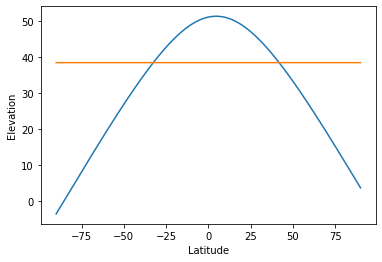

In [23]:
#Call getLocation functionn to return location information from getAngle function

df2, nlat, nlong = getLocation(decrad, elevrad, azimrad, LT, tz, HRArad, LST, d)
df2.head(10)


The plot above display the intersection of the known elevation and a series of latitude values estimated from the getLatitude 
function. Since the elevation is known, then the correct latitude must be at either of these 2 points. Fortunately, the 2 points are very far apart in this example and are on opposite sides of the equator. This is not always true, but numerical approximation is good enough within a margin of error.

The last example is great but we want a realistic way to calculate the location and this requires that the Hour Angle is known from observation. The easiest way to get the hour angle is when it equals 0 at solar noon. The getNoon function will generate the time at noon for a location.

In [25]:
#Function to get time of solar noon for specific city

def getNoon(data2, tz, city,country, d=-1):
    lat,long, latrad, longrad, name = findCity(data2,city, country)
    radB, Eot, TC, d= getTC(tz, long, d)
    minute=0
    hour=11
    LST=0
    while LST<12:
        LT= hour + minute/60
        LST=LT+(TC/60)
        if LST>12:
            if minute>120:
                hour=13
                minute=minute-120
            elif minute>60:
                hour=12
                minute=minute-60
            else:
                hour=11
                minute=minute
            minute= minute-1
        minute=minute+1
    
    LT=hour+(minute/60)
    return hour, minute, LST, LT

In [26]:
#Call getNoon function

hour, minute, LST, LT = getNoon(data2, tz=-5, city='Houston', country='United States', d=270)

print('LST:',LST,' LT:', LT)

LST: 12.004752759911966  LT: 13.2


,city,country,lat,lng,latdf,lngdf,Distance,direction
Rank,,,,,,,,
0,Houston,United States,29.7863,-95.3889,-0.019175,1.421085e-14,2.132158,-90.000000
1,West University Place,United States,29.7157,-95.4321,-0.089775,-4.320000e-02,10.818506,-115.697009
2,Aldine,United States,29.9122,-95.3785,0.106725,1.040000e-02,11.909586,84.434290
3,Bellaire,United States,29.7040,-95.4622,-0.101475,-7.330000e-02,13.318675,-125.842301
4,Jacinto City,United States,29.7663,-95.2410,-0.039175,1.479000e-01,14.922973,-14.835516
5,Galena Park,United States,29.7452,-95.2333,-0.060275,1.556000e-01,16.445431,-21.174934
6,Jersey Village,United States,29.8903,-95.5721,0.084825,-1.832000e-01,20.028673,155.154978
7,Cloverleaf,United States,29.7882,-95.1724,-0.017275,2.165000e-01,20.979109,-4.562078
8,South Houston,United States,29.6611,-95.2285,-0.144375,1.604000e-01,22.306618,-41.990165


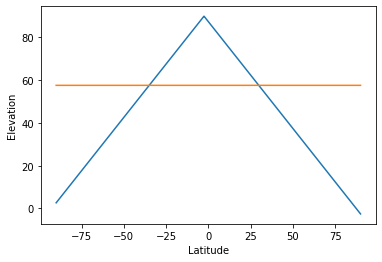

In [27]:
#Call functions with solarnoon requirement to get location

elevrad, azimrad, latrad, longrad, decrad, HRArad,LT, LST, tz, d =getAngle(data2, tz=-5, city='Houston', country='United States', d=270, hour=hour, minute=minute)

df2, nlat, nlong = getLocation(decrad, elevrad, azimrad, LT, tz, HRArad, LST, d)
df2.head(10)

At solar noon when the sun has reached the highest elevation, HRA equals 0. This makes the cos(HRA) term equal 1. Since declination can be found with getLongitude function, that simplifies the Elevation equation enough so that Latitude can be calculated with knowledge of the time and angle of the sun in the sky. 

elevrad=np.arcsin( math.sin(decrad)*math.sin(latrad) + math.cos(decrad)*math.cos(latrad)*math.cos(HRArad) )

=np.arcsin(constant * math.sin(latrad) + constant * math.cos(latrad))

In [29]:
#Variables LT, tz, LST, d are the same as previous solar noon example
#Set these variables to real values to get results for a new example

elevrad=elevrad
azimrad=azimrad
LT=LT
LST=LST
d=d

long, TC, d, decrad = getLongitude(LT, tz, LST, d)
equal, equaltemp, temparr, latrads, azi, latrad = getLatitude(decrad, elevrad, azimrad, HRArad=0)
print('Latitude:', (latrad/math.pi)*180,' Longitude:', long)

Latitude: 29.805474961851612  Longitude: -95.38890000000002


The latitude and longitude results are the same but the main difference is that HRA is explicitly set to 0. This is possible using a compass and potractor to get the angles during the middle of the day. Solar Noon happens when the elevation begins to decrease so the angles at that specific time of the day will give the results shown above.
For more information about the equations in this notebook visit:  https://www.pveducation.org/pvcdrom/properties-of-sunlight/the-suns-position